# Surface-Volume Reactions

<div class="admonition note">
**Topics**: Surface reactions, chained reactions, advanced ResultSelector usage, data saving to file.
</div>

In the [previous chapter](Interface_Tutorial_1_wm.ipynb) we declared reactions taking place inside a volume. In this chapter we consider another
type of kinetic reaction, associated with the [steps.model.SurfaceSystem](API_model.rst#steps.API_2.model.SurfaceSystem) container, which defines a
reaction taking place on a surface (or patch) connecting two compartments
(arbitrarily naming one of them the “inner” compartment, and the other one
the “outer” compartment). Reactants and products can therefore be freely moving
around in a volume or embedded in a surface.
Therefore, it is necessary to firstly specify the location of the reactant
and product species.

**_Note_**: *Surface reactions are designed to represent reactions where one
   reactant is embedded in a membrane, but in fact if all reactants and
   products belong to the same compartment and none appear on a patch
   it will behave exactly like the equivalent volume reaction.*

To become familiar with these reactions we will build a simplified version of
the inositol 1,4,5-trisphosphate (IP $_{3}$) model
 (described in Doi T, et al,*Inositol
   1,4,5-Triphosphate-Dependent* $Ca^{\text{2+}}$ *Threshold Dynamics
   Detect Spike Timing in Cerebellar Purkinje Cells*, J Neurosci 2005, 25(4):950-961) in STEPS.
   
![The IP3 receptor model](images/ip3_2.png)
 
In the IP3 receptor model, reactions (i.e. receptor binding of calcium and IP3 molecules) take place on the membrane separating the Endoplasmic Reticulum (ER) and the cytosol. Therefore, we will need to declare surface reactions.
   
In the figure below we can see a  schematic diagram of the states
and transitions in the model. IP3 receptors are embedded in the ER membrane, each “binding” reaction is described
by a second order surface reaction and each “unbinding” reaction by a first order surface reaction.
 
![The IP3 receptor kinetic scheme](images/ip3_model.png)


We will go through the Python code to build this model in STEPS,
but providing only brief descriptions of operations we are familiar
with from the previous chapter.

## Model declaration

## Surface reactions

STEPS surface reactions can deal with three types of reactions, classified by the locations of the reactants:

- **Volume-Surface reactions**.   In this case molecules within a volume interact with molecules embedded in a surface and result in products that may reside within in a volume or a surface. The units for the reaction parameters in this case are the same as for ordinary volume reactions, namely: a first order reaction parameter has units $s^{-1}$; a second order reaction parameter has units $\left(M.s\right)^{-1}$; a third order reaction $\left(M^{2}.s\right)^{-1}$; and so on.

- **Surface-Surface reactions**.   In this case the reactants are all embedded in a surface. Quite clearly, the dimensions of the reaction are different from a volume reaction and the reaction parameter is assumed to be two-dimensional. This is an important point because the reaction parameter will be treated differently from a volume-volume or volume-surface interaction. A further complication is that parameters for ordinary volume reactions are based on the litre, where there is no convenient equivalent 2D concentration unit.   Surface-surface reaction parameters are based on units of area of **square meters**. **A first order surface-surface reaction parameter is therefore required in units of** $s^{-1}$; **a second-order surface-surface reaction parameter has units** $\left(mol.m^{-2}\right)^{-1}.s^{-1}$; **a third-order surface-surface reaction parameter has units** $\left(mol.m^{-2}\right)^{-2}.s^{-1}$; and so on.   Zero-order surface reactions are not supported because of the ambiguity of interpreting the reaction parameter.

- **Volume-Volume reactions**. 
   It is possible for a surface reaction to contain reactant species that are all in a volume, in which case the reaction behaves similarly to an ordinary volume reaction, though products may belong to connected volumes or surfaces.

As mentioned previously, to declare surface reactions we have to include some information about the location of the reaction:
which compartment are the reactants to be found in, and are any molecules embedded in a surface and which of the two compartments that the surface connects are the products injected into? We supply this information to STEPS by labelling our compartments that a patch connects, arbitrarily choosing the labels 'inner' and 'outer'. When the surface reaction's parent surface system object is added to a certain patch, the compartment labelling in the surface reaction stoichiometry will match the compartment labelling in the patch definition. We will come to creating a patch later in this chapter.

So, at this stage we must chose which compartment we will label 'outer'
and which we will label 'inner' and make sure to maintain this labelling
throughout our definitions, and also in our geometry description.
We chose to label the cytosol as the 'outer' compartment and the ER
as the 'inner' compartment, so should be very careful that this ties in correctly to our description when
we create our [steps.geom.Patch](API_geom.rst#steps.API_2.geom.Patch) object to represent a surface to connect the two compartments.

When writing a surface reaction, we can specify the location of each reactant in two different ways. The most verbose consist in using functions [In](API_model.rst#steps.API_2.model.In), [Out](API_model.rst#steps.API_2.model.Out) and [Surf](API_model.rst#steps.API_2.model.Surf) to refer respectively to the inner compartment, the outer compartment, and the patch surface:
```python
Surf(R) + Out(IP3) <r[1]> Surf(RIP3)
```

The same reactions can be declared in a slightly more concised way:
```python
R.s + IP3.o <r[1]> RIP3.s
```

Adding `.s`, `.i`, or `.o` after a reactant is a shorthand way to specify its location. This notation aims at imitating subscripts like in: $\mathrm{R_s + IP3_o \leftrightarrow RIP3_s}$

__Note__: *Reactant species cannot belong to different compartments,
   so attempting to create a surface reaction with both `Spec1.i` and `Spec2.o` *will
   result in an error.*

## Surface reactions declaration

Let us now declare all our reactions. As in the previous chapter, we first import the required packages, create the `Model`, a `ReactionManager`, and declare `Species`:

In [1]:
import steps.interface

from steps.model import *
from steps.geom import *
from steps.rng import *
from steps.sim import *
from steps.saving import *

r = ReactionManager()

mdl = Model()

with mdl:
    Ca, IP3, R, RIP3, Ropen, RCa, R2Ca, R3Ca, R4Ca = Species.Create()
    surfsys = SurfaceSystem.Create()
    
    with surfsys:
        # IP3 and activating Ca binding
        R.s    + IP3.o <r['r1']> RIP3.s
        RIP3.s + Ca.o  <r['r2']> Ropen.s
        r['r1'].K = 1000e6, 25800
        r['r2'].K = 8000e6, 2000
        
        # Inactivating Ca binding
        R.s    + Ca.o <r['r3']> RCa.s
        RCa.s  + Ca.o <r['r4']> R2Ca.s
        R2Ca.s + Ca.o <r['r5']> R3Ca.s
        R3Ca.s + Ca.o <r['r6']> R4Ca.s
        r['r3'].K = 8.889e6, 5
        r['r4'].K = 20e6, 10
        r['r5'].K = 40e6, 15
        r['r6'].K = 60e6, 20

        # Ca ions passing through open IP3R channel
        Ca.i + Ropen.s >r[1]> Ropen.s + Ca.o
        r[1].K = 2e8

Note that each possible state of an IP3 receptor is declared as a dinstinct species.
We then declare a `SurfaceSystem` instead of a `VolumeSystem` and the reactions are declared using the context manager `with` keyword, as previously seen.
All reactions are biderectional (using `<r[...]>`) except for the last one (using `>r[...]>`), that represents calcium leaving the ER through the open IP3R channel.

By using the `.K` property, we set all reaction constants' default values (see Doi T, et al,*Inositol
   1,4,5-Triphosphate-Dependent* $Ca^{\text{2+}}$ *Threshold Dynamics
   Detect Spike Timing in Cerebellar Purkinje Cells*, J Neurosci 2005, 25(4):950-961). Since these are volume-surface interactions, we must make
sure to supply our values in Molar units as  discussed previously in this chapter.

Note that, when several reactants bind sequentially (to a receptor like here for example), it is possible to chain the reactions using parentheses:
```python
(R.s + IP3.o <r[1]> RIP3.s) + Ca.o <r[2]> Ropen.s
```
Reactions that are in parentheses are equivalent to their right hand side. The above line thus first declares the reaction in the parentheses `R.s + IP3.o <r[1]> RIP3.s` and replaces it by its right hand side; the line then reads `RIP3.s + Ca.o <r[2]> Ropen.s` and this reaction is declared. The whole process is thus equivalent to declaring the reactions on two separate lines.
<div class="admonition warning">
    **Warning**: Chained reactions can be a bit hard to read so their use should probably be restricted to sequential bindings.
</div>

## Geometry specification

The next step is to create the geometry for the model. We will choose well-mixed
geometry, as in the [chapter on well-mixed models](Interface_Tutorial_1_wm.ipynb), but we now have two compartments which
are connected by a surface 'patch'. We create two [steps.geom.Compartment](API_geom.rst#steps.API_2.geom.Compartment) objects
to represent the Endoplasmic Reticulum (which we intend to label the 'inner'
compartment) and the cytosol ('outer' compartment), and a [steps.geom.Patch](API_geom.rst#steps.API_2.geom.Patch)
object to represent the ER membrane between the ER and cytosol.

In [2]:
geom = Geometry()
with geom:
    # Create the cytosol and Endoplasmic Reticulum compartments
    cyt, ER = Compartment.Create()
    cyt.Vol = 1.6572e-19
    ER.Vol = 1.968e-20

    # ER is the 'inner' compartment, cyt is the 'outer' compartment
    memb = Patch.Create(ER, cyt, surfsys)
    memb.Area = 0.4143e-12

First we create the two well-mixed compartments at once with `cyt, ER = Compartment.Create()`. Since no parameters were given to `Create()`, we explicitely set the volume of each compartment by using the `.Vol` property.
Since we only defined a `SurfaceSystem` in the model, we do not need to associate our compartment with a `VolumeSystem`.

We then create the `Patch` using the automatic naming syntax. This time, the `Create` method needs to receive at least the inner compartment. 
It is vital that care is taken in the order of the compartment objects to the constructor, so that the required labelling from our surface reaction
definitions is maintained. **Note**: *A Patch must have an inner compartment by convention,
   but does not require an outer compartment. This is an easy way to remember the order to the constructor; since an inner compartment is always required it must come first to the constructor, and the optional outer compartment comes after. Obviously any surface reaction
   rules that contain reactants or products in the outer compartment cannot be
   added to a Patch that doesn't have an outer compartment.*

We can also specify the area of the patch during creation, like so:
```python
patchName = Patch.Create(innerComp, outerComp, surfSys, area)
```
In our example, we set the area of a patch after creation using the `.Area` property.

We can check the labelling is as desired after object construction if we like with properties [steps.geom.Patch.innerComp](API_geom.rst#steps.API_2.geom.Patch.innerComp) and [steps.geom.Patch.outerComp](API_geom.rst#steps.API_2.geom.Patch.outerComp).:


In [3]:
print(memb.innerComp)
print(memb.outerComp)

ER
cyt


## Simulation declaration and data saving

We first create the random number generator and the `Simulation`. Like in the previous chapter, we will use the well-mixed `'Wmdirect'` solver:

In [4]:
rng = RNG('mt19937', 512, 7233)

sim = Simulation('Wmdirect', mdl, geom, rng)

Model checking:
No errors were found


We then specify which data should be saved, this time we will declare two result selectors:

In [5]:
rs = ResultSelector(sim)

Rstates = rs.memb.MATCH('R.*').Count

Reacs = rs.memb.MATCH('r[1-6]')['fwd'].Extent + rs.memb.MATCH('r[1-6]')['bkw'].Extent

We have two `ResultSelector`s, `Rstates` and `Reacs`. `Rstates` makes use of the `MATCH(...)` function that only selects objects whose name matches the [regular expression](https://docs.python.org/3/howto/regex.html) given as a parameter. In our case, it will match all objects inside `memb` whose name starts with 'R', i.e. all receptors. It is equivalent to the longer:
```python
Rstates = rs.memb.LIST(R, RIP3, Ropen, RCa, R2Ca, R3Ca, R4Ca).Count
```
In our specific case, it happens to be equivalent to `rs.memb.ALL(Species).Count` because we did not define any other species on the ER membrane. The `MATCH` version is however preferable since it will still work if we decide to add other species.

### Combining ResultSelectors

<img src="images/resultselector_syntax.png"/>

The second `ResultSelector`, `Reacs` will save the extent of each reaction from 'r1' to 'r6', taking into account both forward and backward subreactions. To understand its declaration, we first need to see how reactions interact with `ResultSelector`s.
The following `ResultSelector` will save both forward and backward extent of reaction 'r1':
```python
rs.memb.r1.Extent
```
Since it saves two values for each run and for each timestep (i.e. the third dimension of the associated data structure is 2, cf. previous tutorial), and for the sake of simplicity, we will say that it has length 2. To save specifically the forward extent, we write:
```python
rs.memb.r1['fwd'].Extent
```
and this `ResultSelector` has length 1. To save the total extent (the sum of forward and backward), one could write:
```python
rs.SUM(rs.memb.r1.Extent)
```
the `rs.SUM(...)` function takes a `ResultSelector` as an argument and returns a `ResultSelector` whose length is 1 and corresponds to the sum of all the values defined by the argument. In our case, it would be equivalent to:
```python
rs.memb.r1['fwd'].Extent + rs.memb.r1['bkw'].Extent
```
This `+` notation is also valid; standard arithmetic operators (`+`, `-`, `*`, `/`, and `**`) can all be used with `ResultSelector`s and behave in the same way as they do in numpy. The above example sums two `ResultSelector`s of length 1 and thus results in a `ResultSelector` of length one as well. If the length of the operands is higher than one, like in:
```python
rs.memb.LIST(r1, r2)['fwd'].Extent + rs.memb.LIST(r1, r2)['bkw'].Extent
```
the resulting `ResultSelector` has length 2, like the operands, and is equivalent to:
```python
rs.memb.r1['fwd'].Extent + rs.memb.r1['bkw'].Extent << rs.memb.r2['fwd'].Extent + rs.memb.r2['bkw'].Extent
```
In our main example, `Reacs` has length 6 and saves the total extent of each reaction whose name matches the regular expression 'r\[1-6\]' (the name has to start with character 'r' and then a number between 1 and 6).

### Editing labels

As we saw in the previous tutorial, labels are automatically generated when using `ResultSelector`s and can be accessed with e.g. `Rstates.labels`. With the same notation, it is also possible to provide custom labels by simply using:
```python
selector.labels = ['label 1', 'label2', ...]
```
The length of the list needs to match the length of the `ResultSelector`. Here, we will modify the automatically generated labels of `Rstates` which currently look like this: 

In [6]:
print(Rstates.labels)

['memb.R.Count', 'memb.R2Ca.Count', 'memb.R3Ca.Count', 'memb.R4Ca.Count', 'memb.RCa.Count', 'memb.RIP3.Count', 'memb.Ropen.Count']


Instead, we would like to only keep the species name:

In [7]:
Rstates.labels = [l.split('.')[1] for l in Rstates.labels]

print(Rstates.labels)

['R', 'R2Ca', 'R3Ca', 'R4Ca', 'RCa', 'RIP3', 'Ropen']


### Saving data to files

Finally, in order to save the data to files, we simply need to call the `toFile` method on the `ResultSelector` objects and provide it with the file path. The data from all runs will be saved to the same file in binary format. We then need to remember to associate both `ResultSelector`s to the simulation and specify how frequently they should be saved:

In [8]:
Rstates.toFile('Rstates.dat')
Reacs.toFile('Reacs.dat')

sim.toSave(Rstates, Reacs, dt=0.001)

If the results needed to be saved at different intervals, we could of course write:
```python
sim.toSave(Rstates, dt=0.001)
sim.toSave(Reacs, dt=0.005)
```
In addition, if we wanted to save the data at specified timepoints, we could use the `timePoints` argument:
```python
sim.toSave(Reacs, timePoints=[0.0, 0.01, 0.03, 0.15])
```

### Running the simulation

Having defined and added all `ResultSelector`s, we can then run the simulation:

In [9]:
NITER = 100
ENDT = 0.201

for i in range (0, NITER):
    sim.newRun()

    sim.cyt.Ca.Conc = 3.30657e-8
    sim.cyt.IP3.Count = 6
    sim.ER.Ca.Conc = 150e-6
    sim.ER.Ca.Clamped = True
    sim.memb.R.Count = 160

    sim.run(ENDT)

Let us then assume that the previous code was executed on a computing machine and the following code is executed on a distinct machine. To emulate this, we can reset the jupyter kernel with:

In [10]:
%reset -f

## Loading saved data

Now we do not have access to the variables we declared previously and thus cannot plot data using `Rstates.data` like we did before. Instead, we first need to load the files to which we saved the data:

In [11]:
import steps.interface

from steps.saving import *
from matplotlib import pyplot as plt
import numpy as np

ldRstates = ResultSelector.FromFile('Rstates.dat')
ldReacs   = ResultSelector.FromFile('Reacs.dat')

The `ldRstates` and `ldReacs` objects now behave like the `Rstates` and `Reacs` objects in the simulation script, we can thus use them transparently to plot the data. We will first plot the time course of the number of receptors in the open state:

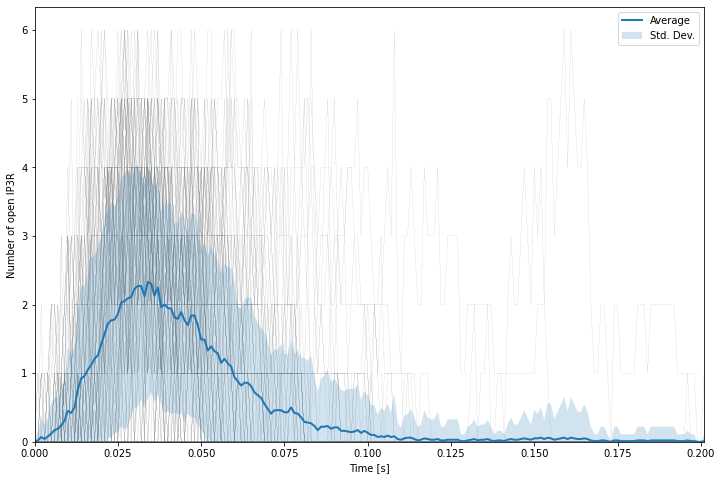

In [12]:
plt.figure(figsize=(12,8))

RopenInd = ldRstates.labels.index('Ropen')
RopenData = ldRstates.data[:, :, RopenInd]

time = ldRstates.time[0]
mean = np.mean(RopenData, axis=0)
std = np.std(RopenData, axis=0)

plt.plot(time, mean, linewidth=2, label='Average')
plt.fill_between(time, mean - std, mean + std, alpha=0.2, label='Std. Dev.')

for t, d in zip(ldRstates.time, RopenData):
    plt.plot(t, d, color='grey', linewidth=0.1, zorder=-1)

plt.ylim(0)
plt.margins(0, 0.05)
plt.xlabel('Time [s]')
plt.ylabel('Number of open IP3R')
plt.legend()
plt.show()

We first need to extract the data for `Ropen` from `ldRstates`. We do so by using `ldRstates.labels`; we are interested in `memb.Ropen.Count` so we simply call the python `index` method that returns the index of the `Ropen` data in the whole selector.
We then get the corresponding data with `ldRstates.data[:, :, RopenInd]`, the two first dimensions (runs and time) are untouched and we only take the data relative to `Ropen`.

In order to display the trace corresponding to each run, we iterate on the data with:
```python
for t, d in zip(ldRstates.time, RopenData):
    plt.plot(t, d, color='grey', linewidth=0.1, zorder=-1)
```

We would then like to look at the time course of all receptor states:

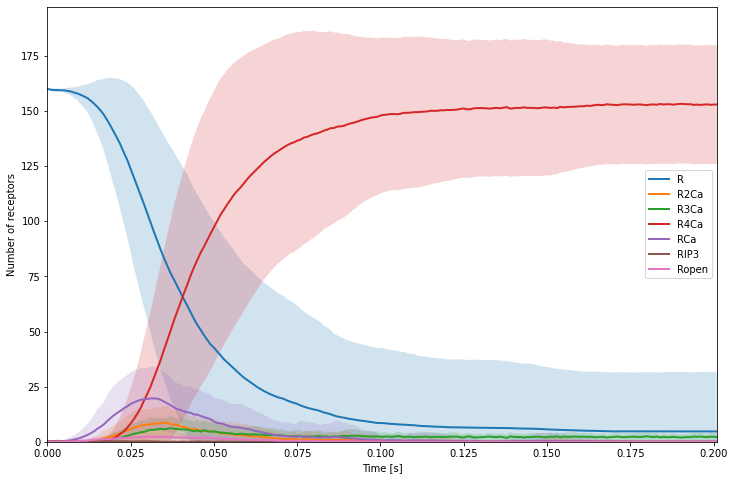

In [13]:
plt.figure(figsize=(12,8))

time = ldRstates.time[0]
mean = np.mean(ldRstates.data, axis=0)
std = np.std(ldRstates.data, axis=0)

plt.plot(time, mean, linewidth=2)
for m, s in zip(mean.T, std.T):
    plt.fill_between(time, m - s, m + s, alpha=0.2)

plt.legend(ldRstates.labels)
plt.xlabel('Time [s]')
plt.ylabel('Number of receptors')
plt.ylim(0)
plt.margins(0, 0.05)
plt.show()

Since `fill_between` cannot take all data at once, like `plot` can, we needed to iterate over the different receptor states in `mean` and `std`. To do so, we used:
```python
for m, s in zip(mean.T, std.T):
    plt.fill_between(time, m - s, m + s, alpha=0.2)
```
both `mean` and `std` have dimension `(nbT, nbR)` with `nbT` the number of saved time points and `nbR` the number of receptor states. Since the first dimension corresponds to time, if we were to directly iterate over `mean` and `std`, we would iterate over time instead of iterating over receptor states. We thus first transpose the matrices with `mean.T` and `std.T`.

We then turn to plotting data from `ldReacs`:

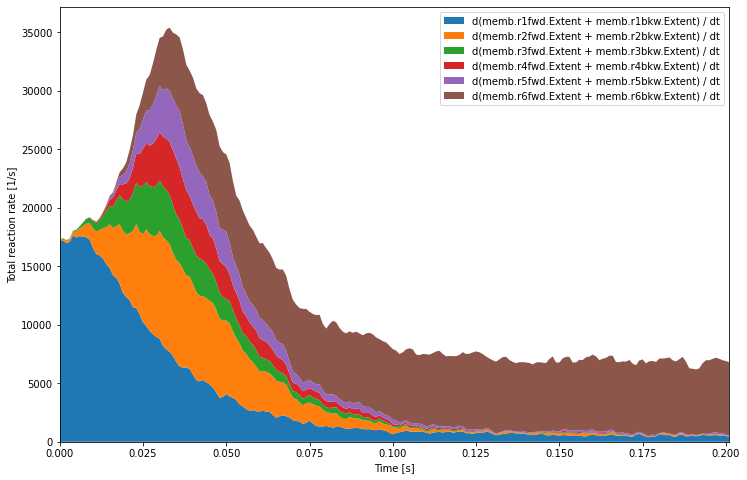

In [14]:
plt.figure(figsize=(12,8))

time = ldReacs.time[0]
dt = time[1] - time[0]
meanDeriv = np.mean(np.gradient(ldReacs.data, dt, axis=1), axis=0)

plt.stackplot(time, meanDeriv.T)

plt.legend([f'd{l} / dt' for l in ldReacs.labels])
plt.margins(0, 0.05)
plt.xlabel('Time [s]')
plt.ylabel('Total reaction rate [1/s]')
plt.show()

Here we want to look at the repartition of the actual rates of reactions. We use the [np.gradient](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html) function that computes the derivative of the data with respect to the time axis (`axis=1`). We then average the values across runs using `np.mean` with `axis=0`. This time derivative of the extent of each reaction is a good proxy for the instantaneous actual rate of this reaction.